In [10]:
# Source from: https://colab.research.google.com/drive/1OZpmLgd5D_qmjTnL5AsD1_ZJDdb7LQZI?usp=sharing#scrollTo=KH546j3nkFwX
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from transformers import AutoTokenizer
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain
model_path = './models/llama-2-7b-chat.Q4_K_M.gguf'

# 1. Loading PDFs and chunking with LangChain

In [11]:
# Simple method - Split by pages 
loader = PyPDFLoader("./docs/attention-is-all-you-need-Paper.pdf")
pages = loader.load_and_split()
print(len(pages))
print(pages[0])

# SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
chunks = pages

12
page_content='Attention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.comNoam Shazeer∗\nGoogle Brain\nnoam@google.comNiki Parmar∗\nGoogle Research\nnikip@google.comJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.comAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurrence and convolutions\nentirely. Experiments on two machine translation tasks show these models to\nbe superior in quality while being more parallelizable and requiring signiﬁ

In [12]:
# Advanced method - Split by chunk

# Step 1: Convert PDF to text
import textract
doc = textract.process(r"./docs/attention-is-all-you-need-Paper.pdf")

# Step 2: Save to .txt and reopen (helps prevent issues)
with open('./docs/attention-is-all-you-need-Paper.txt', 'w', encoding="utf-8") as f:
    f.write(doc.decode('utf-8'))

with open('./docs/attention-is-all-you-need-Paper.txt', 'r', encoding="utf-8") as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
# tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-chat-hf")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

vocab.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 3.50MB/s]
c:\Hiwi_Project\langchain-local-model\venv\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\n9102\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 

In [13]:
type(chunks[0])

langchain_core.documents.base.Document

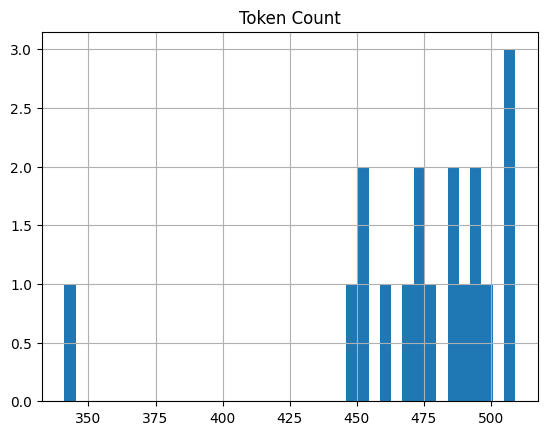

In [14]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

# 2. Embed text and store embeddings

In [15]:
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.embeddings import LlamaCppEmbeddings
from langchain_community.vectorstores import Chroma

# Get embedding model
# embeddings = OpenAIEmbeddings()
embeddings = GPT4AllEmbeddings()
# embeddings = LlamaCppEmbeddings(model_path=model_path)

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings)

# 3. Set up local LLM using LlamaCpp

In [16]:
from langchain_community.llms import LlamaCpp

n_gpu_layers = 1  # Metal set to 1 is enough.
n_batch = 512  # Should be between 1 and n_ctx, consider the amount of RAM of your Apple Silicon Chip.

llm = LlamaCpp(
    model_path=model_path,        
    n_gpu_layers=n_gpu_layers,
    n_batch=n_batch,
    n_ctx=2048,
    f16_kv=True,  # MUST set to True, otherwise you will run into problem after a couple of calls
    verbose=True,
)

AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 0 | VSX = 0 | 


# 4. Setup retrieval function

In [17]:
# Check similarity search is working
query = "Who created transformers?"
docs = vectorstore.similarity_search(query)
docs[0]

Document(page_content='To the best of our knowledge, however, the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequencealigned RNNs or convolution. In the following sections, we will describe the Transformer, motivate self-attention and discuss its advantages over models such as [14, 15] and [8].\n\n3 Model Architecture\n\nMost competitive neural sequence transduction models have an encoder-decoder structure [5, 2, 29]. Here, the encoder maps an input sequence of symbol representations (x1, ..., xn) to a sequence of continuous representations z = (z1, ..., zn). Given z, the decoder then generates an output sequence (y1, ..., ym) of symbols one element at a time. At each step the model is auto-regressive [9], consuming the previously generated symbols as additional input when generating the next.\n\nThe Transformer follows this overall architecture using stacked self-attention and point-wi

In [18]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(llm, chain_type="stuff")

query = "Who created transformers?"
docs = vectorstore.similarity_search(query)

chain.run(input_documents=docs, question=query)

' Jakob Uszkoreit, Ashish Vaswani et al.'

# 5. Create chatbot with chat memory

In [20]:
from IPython.display import display
import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(llm, vectorstore.as_retriever())

In [21]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""
    
    if query.lower() == 'exit':
        print("Thank you for using the State of the Union chatbot!")
        return
    
    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))
    
    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the Transformers chatbot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

Welcome to the Transformers chatbot! Type 'exit' to stop.


C:\Users\n9102\AppData\Local\Temp\ipykernel_2588\3970211031.py:20: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  input_box.on_submit(on_submit)


Text(value='', placeholder='Please enter your question:')

Llama.generate: prefix-match hit


HTML(value='<b>User:</b> Who created transformers?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  The Transformer was proposed by several authors, includ…

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


HTML(value='<b>User:</b> Were they smart?')

HTML(value='<b><font color="blue">Chatbot:</font></b>   The authors proposed the Transformer using a stacked s…

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


HTML(value='<b>User:</b>  I think they were')

HTML(value='<b><font color="blue">Chatbot:</font></b>   I can provide information on the authors who proposed …